In [21]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [22]:
from typing import Callable, Sequence

class Unit:
    def __init__(self):
        pass
        
    def initialize(self, predecessors, successors):
        pass
        
    def deriv(self,h: float,t, qin, qout):
        pass
    
    def plot(self):
        pass
    
    def update(self,t, predecessors, successors):
        pass

In [23]:
class Reservoir(Unit):
    
    def __init__(self, name: str, A: Callable[[float], float], IC: float, datum: float= 0) -> None:
        self.name = name
        self.A_func = A
        self.datum = datum
        
        self.IC = IC
        
    def initialize(self, predecessors: Sequence[Unit], successors: Sequence[Unit]) -> None:
        self.t = 0
        self.h = self.IC
        self._log = {'t':[], 'h':[]}
        self._log['t'].append(self.t)
        self._log['h'].append(self.h)
        
    def deriv(self,t: float, h: float, qin: float, qout: float) -> float:
        dh = (qin - qout)/self.A_func(h)
        return dh
    
    def plot(self) -> None:
        t = self._log['t']
        h = self._log['h']
        plt.plot(t,h,label=self.name + ' h')
        plt.legend()
    
    def get_water_height(self) -> float:
        return self.h
    
    def get_water_level(self) -> float:
        return self.h + self.datum
    
    def update(self, t: float, predecessors: Sequence[Unit], successors: Sequence[Unit]) -> None:
        qin = 0
        for node in predecessors:
            qin += node.q
        qout = 0
        for node in successors:
            qout += node.q
        
        self.h = float(odeint(lambda x,t: self.deriv(t, x, qin, qout), self.h, [self.t, t])[-1])
        self._log['t'].append(t)
        self._log['h'].append(self.h)
        self.t = t

In [24]:
class Source:
    def __init__(self, func_: Callable[[float], float]):
        self.func_ = func_
        
    def initialize(self, predecessors: Sequence[Unit], successors: Sequence[Unit]):
        self.update(0,predecessors, successors)
        
    def update(self, t, predecessors: Sequence[Unit], successors: Sequence[Unit]):
        self.q = self.func_(t, predecessors, successors)

class Sink():
    def initialize(self, predecessors: Sequence[Unit], successors: Sequence[Unit]):
        pass
    
    def update(self, t, predecessors: Sequence[Unit], successors: Sequence[Unit]):
        pass

In [25]:
class Valve():
    def __init__(self, Cv: float, opening_func: Callable[[float], float]):
        self.Cv = Cv
        self.opening_func = opening_func
        self.u = 0
        
    def initialize(self, predecessors: Sequence[Unit], successors: Sequence[Unit]):
        self.update(0,predecessors,successors)
    
    def update(self, t: float, predecessors: Sequence[Unit], successors: Sequence[Unit]):
        self.u = self.opening_func(t,predecessors,successors)
        h = predecessors[0].get_water_height()
        self.q = self.u*self.Cv*np.sqrt(h)
    

In [26]:
class Pump_Turbine():
    def __init__(self, flow_func: Callable[[float], float]):
        self.flow_func = flow_func
        
    def initialize(self, predecessors: Sequence[Unit], successors: Sequence[Unit]):
        self.update(0,predecessors,successors)
    
    def update(self, t, predecessors: Sequence[Unit], successors: Sequence[Unit]):
        self.q = self.flow_func(t,predecessors,successors)

In [27]:
class SimulationProblem():
    def __init__(self, dt: float=0.01):
        self.graph = nx.DiGraph()
        self.dt = dt
    
    def connect(self, element1: Unit, element2: Unit):
        self.graph.add_edge(element1, element2)
    
    def connect_multiple(self, list_of_elements: Sequence[Unit]):
        self.graph.add_edges_from(list_of_elements)
    
    def initialize(self):
        for node in nx.topological_sort(self.graph):
            predecessors = list(self.graph.predecessors(node))
            successors = list(self.graph.successors(node))
            node.initialize(predecessors, successors)
    
    def simulate(self, t_end:float):
        dt = self.dt
        for t in np.arange(dt,t_end,dt):
            for node in nx.topological_sort(self.graph):
                predecessors = list(self.graph.predecessors(node))
                successors = list(self.graph.successors(node))
                node.update(t, predecessors, successors)


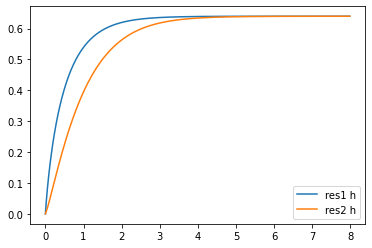

In [28]:
def qin(t, predecessors, successors):
    return 0.4

def v1_opening(t, predecessors, successors):
    return 1

def v2_opening(t, predecessors, successors):
    return 1

source = Source(qin)
res1 = Reservoir(name='res1', A = lambda h: 0.2, IC=0)
v1 = Valve(0.5, v1_opening)
res2 = Reservoir(name='res2', A = lambda h: 0.2, IC=0)
v2 = Valve(0.5, v2_opening)
sink = Sink()

sim = SimulationProblem()
sim.connect_multiple([
    (source, res1),
    (res1, v1),
    (v1, res2),
    (res2, v2),
    (v2, sink ),
])
sim.initialize()
sim.simulate(8)

res1.plot()
res2.plot()

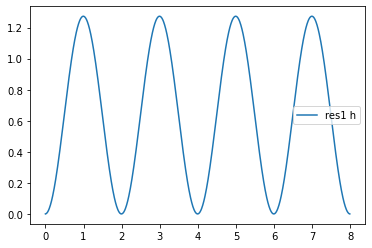

In [29]:
def qin(t, predecessors, successors):
    return 5 + 2 *np.sin(np.pi*t)

def pump_flow(t, predecessors, successors):
    return 5

source = Source(qin)
res1 = Reservoir(name='res1', A = lambda h: 1, IC=0)
p1 = Pump_Turbine(pump_flow)
sink = Sink()

sim = SimulationProblem()
sim.connect_multiple([
    (source, res1),
    (res1, p1),
    (p1, sink ),
])

sim.initialize()
sim.simulate(8)

res1.plot()

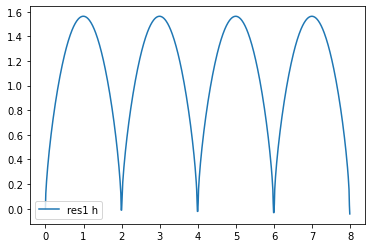

In [30]:
def qin(t, predecessors, successors):
    return 5 + 2 *np.sin(np.pi*t)

def pump_flow(t, predecessors, successors):
    return 5

source = Source(qin)
res1 = Reservoir(name='res1', A = lambda h: h**2, IC=1e-5)
p1 = Pump_Turbine(pump_flow)
sink = Sink()

sim = SimulationProblem(0.01)
sim.connect_multiple([
    (source, res1),
    (res1, p1),
    (p1, sink ),
])

sim.initialize()
sim.simulate(8)

res1.plot()

# importing model

In [31]:
import yaml

with open('model.yaml') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)
print(data)

{'model': {'name': 'Example', 'components': {'inflow': {'name': 'inflow', 'Q': 'q_in'}, 'storage': {'name': 'storage', 'V': 'V_storage', 'nominal': '4e5', 'min': '2e5', 'max': '6e5'}, 'pipe': {'name': 'release', 'Q': 'q_release', 'min': 0.0, 'max': 6.5}, 'terminal': {'name': 'outfall'}}, 'inputs': {'q_in': {'fixed': True}}, 'outputs': ['V_storage', 'q_release'], 'connnections': {'inflow': 'storage', 'storage': 'pipe', 'pipe': 'terminal'}}}


In [32]:
for node_name, node_data in data['model']['components'].items():
    if node_name == 'inflow':
        Q_name = node_data['Q']
        name = node_data['name']
        source = Source(qin)
    elif node_name == 'storage':
        pass
    elif node_name == 'pipe':
        pass
    elif node_name == 'terminal':
        pass

SyntaxError: invalid syntax (<ipython-input-32-3370d3bf9664>, line 10)